C:\Users\Bhanu\AppData\Local\Temp\ipykernel_3112\3607963031.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_profile['SignupDate'] = pd.to_datetime(customer_profile['SignupDate'])
C:\Users\Bhanu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\Bhanu\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  wa

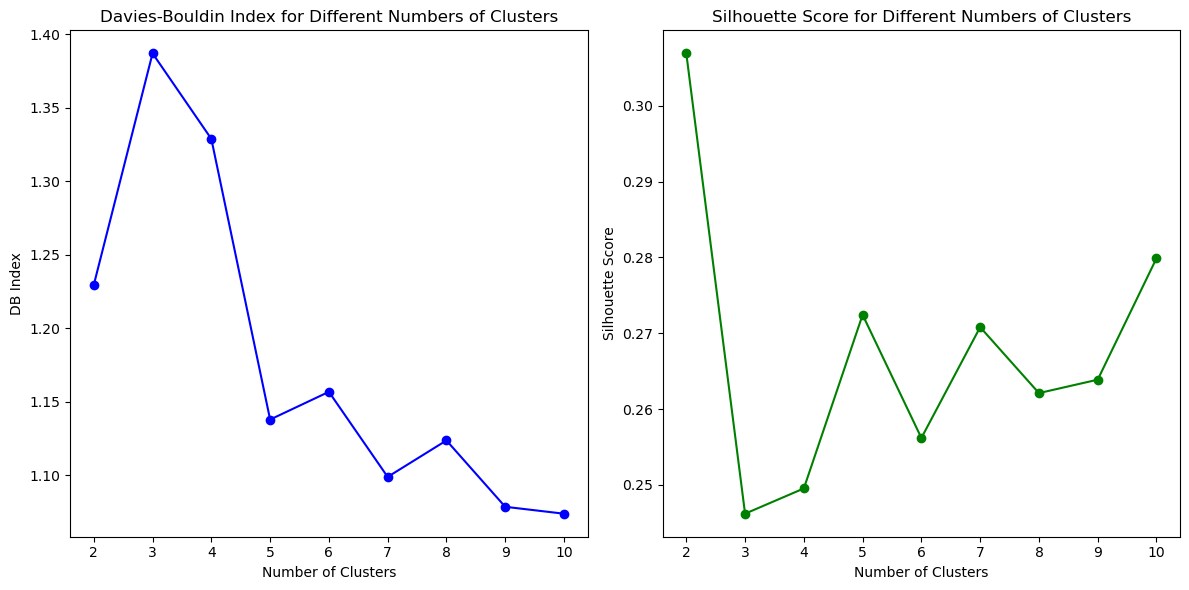

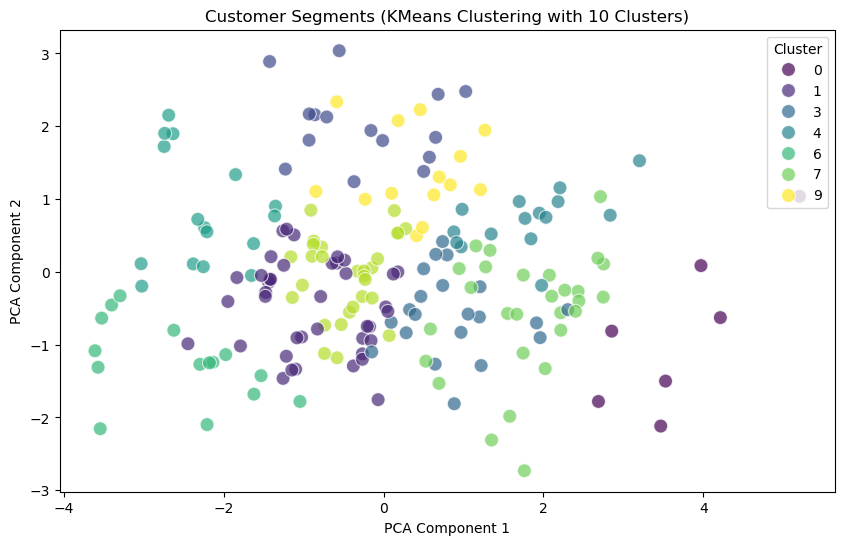

Number of clusters: 10
Davies-Bouldin Index: 1.0740
Silhouette Score: 0.2799


In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

# Merge the data to associate transactions with customer information
merged_data = pd.merge(transactions, customers, on='CustomerID', how='left')

# Feature Engineering

# 1. Create customer-level transaction features
customer_features = merged_data.groupby('CustomerID').agg(
    total_spent=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'nunique'),
    num_products_bought=('ProductID', 'nunique'),
    avg_transaction_value=('TotalValue', 'mean')
).reset_index()

# 2. Add customer profile features (Region, SignupDate)
customer_profile = customers[['CustomerID', 'Region', 'SignupDate']]

# Convert SignupDate to number of days since signup
customer_profile['SignupDate'] = pd.to_datetime(customer_profile['SignupDate'])
customer_profile['days_since_signup'] = (pd.to_datetime('today') - customer_profile['SignupDate']).dt.days

# Merge profile features with transaction features
customer_data = pd.merge(customer_features, customer_profile, on='CustomerID', how='left')

# 3. Normalize numerical features
scaler = StandardScaler()
numerical_features = ['total_spent', 'num_transactions', 'num_products_bought', 'avg_transaction_value', 'days_since_signup']
customer_data[numerical_features] = scaler.fit_transform(customer_data[numerical_features])

# Clustering with KMeans

# Set the range of clusters (between 2 and 10 clusters)
cluster_range = range(2, 11)
db_indices = []
silhouette_scores = []

# Store the best clustering model
best_kmeans = None
best_db_index = float('inf')

# Iterate through the cluster range and compute the clustering metrics
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(customer_data[numerical_features])
    
    # Calculate the Davies-Bouldin Index (DB Index) and Silhouette Score
    db_index = davies_bouldin_score(customer_data[numerical_features], kmeans.labels_)
    silhouette_avg = silhouette_score(customer_data[numerical_features], kmeans.labels_)
    
    db_indices.append(db_index)
    silhouette_scores.append(silhouette_avg)
    
    # Keep track of the best clustering model based on DB Index
    if db_index < best_db_index:
        best_db_index = db_index
        best_kmeans = kmeans

# Plot the DB Index and Silhouette Score for different cluster numbers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cluster_range, db_indices, marker='o', linestyle='-', color='b')
plt.title('Davies-Bouldin Index for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')

plt.subplot(1, 2, 2)
plt.plot(cluster_range, silhouette_scores, marker='o', linestyle='-', color='g')
plt.title('Silhouette Score for Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

# Visualize the best clustering model using PCA for dimensionality reduction
best_labels = best_kmeans.labels_

# Perform PCA to reduce dimensions to 2 for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(customer_data[numerical_features])

# Plot the PCA components with cluster labels
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=best_labels, palette='viridis', s=100, alpha=0.7)
plt.title(f'Customer Segments (KMeans Clustering with {best_kmeans.n_clusters} Clusters)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster', loc='upper right')
plt.show()

# Add the cluster labels to the customer data
customer_data['Cluster'] = best_labels

# Summary of the clustering results
num_clusters = best_kmeans.n_clusters
db_index = best_db_index
silhouette_avg = silhouette_score(customer_data[numerical_features], best_labels)

print(f"Number of clusters: {num_clusters}")
print(f"Davies-Bouldin Index: {db_index:.4f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

# Save the clustered data to a CSV file
customer_data.to_csv('Clustered_Customers.csv', index=False)
